1. My take at creating a Risk Scorer model is, trying to create a model really good at predicting whether if study fails, i.e reducing Type-I error, meaning reducing FP (False Positive) error, or in other words increasing recall since {Precision = TP/(TP+FP)}.
So, the model will be able to predict failed studies with 100% accuracy.
2. To achieve this we will be using AUC-ROC curve to evaluate threshold value, we will try to find a threshold value which will help us classify all the failed trials with 100% accuracy with keeping the balance between precision and recall (Which is realy tough theoretically as precision and recall are inter related if one value increases other one decreases).
3. We have 12 different combinations, 4 types of dataframes and 3 different models. I want to find out how far we can increase precision score without using threshold values, by optimizing our models for higher precision score. 
3. We will take best combination and derive our final Risk Scorer model.

In [262]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import pickle
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

global model_name, model, dataframe_type, X_train, X_test, y_train, y_test

output_feature = 'Results'

In [263]:
dataframes = pd.read_pickle('../../data/dataframes.pkl')

In [264]:
models = {
    'random_forest_classifier' : RandomForestClassifier(),
    'ada_boost_classifier' : AdaBoostClassifier(),
    'XGBoost_classifier' : XGBClassifier(),
}

In [265]:
model_params = {}

In [266]:
def objective(trial):

    if model_name == 'ada_boost_classifier':
        params = {
            'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
            'learning_rate' : trial.suggest_float('learning_rate', 0, 1000),
            'algorithm' : trial.suggest_categorical('algorithm', ['SAMME']),
        }
    elif model_name == 'random_forest_classifier':
        params = {
            'n_estimators' : trial.suggest_int('n_estimators', 5, 200),
            'criterion'    : trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini']),
            'max_depth'    : trial.suggest_int('max_depth', 1, 100),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 100),
            'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }
    elif model_name == 'XGBoost_classifier':
        params = {
            "silent": 1,
            "objective": "binary:logistic",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
            params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
            params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # mod = model(**params)
    # mod.fit(X_train, y_train)
    if model_name == 'ada_boost_classifier':
        mod = AdaBoostClassifier(**params)
        mod.fit(X_train, y_train)
    elif model_name == 'random_forest_classifier':
        mod = RandomForestClassifier(**params)
        mod.fit(X_train, y_train)
    elif model_name == 'XGBoost_classifier':
        mod = XGBClassifier(**params)
        mod.fit(X_train, y_train)

    y_pred = mod.predict(X_test)
    # f1_scr = f1_score(y_pred=y_pred, y_true=y_test)
    pre_score = precision_score(y_pred=y_pred, y_true=y_test)
    # recall_scr = recall_score(y_pred=y_pred, y_true=y_test)

    return pre_score

In [267]:
for df_type, df in zip(dataframes.keys(), dataframes.values()):

    dataframe_type = df_type

    for name, mod in zip(models.keys(), models.values()):

        model_name = name
        model = mod
        # print('{} : {}'.format(dataframe_type, model_name))

        X = df.drop(output_feature, axis=1)
        y = df['Results']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=30)

        trial = study.best_trials[0]
        key = model_name + '-' + dataframe_type
        model_params[key] = trial.params.items()

[I 2024-11-19 22:57:52,413] A new study created in memory with name: no-name-3d3bf06c-4915-4442-9b8d-85319f8b3dc0
[I 2024-11-19 22:57:53,379] Trial 0 finished with value: 0.8247011952191236 and parameters: {'n_estimators': 56, 'criterion': 'entropy', 'max_depth': 71, 'min_samples_split': 51, 'min_samples_leaf': 24, 'max_features': 'log2'}. Best is trial 0 with value: 0.8247011952191236.
[I 2024-11-19 22:57:55,145] Trial 1 finished with value: 0.8451969592259848 and parameters: {'n_estimators': 30, 'criterion': 'entropy', 'max_depth': 81, 'min_samples_split': 87, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.8451969592259848.
[I 2024-11-19 22:57:57,424] Trial 2 finished with value: 0.829644533869886 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8451969592259848.
[I 2024-11-19 22:57:57,725] Trial 3 finished with value: 0.816031

In [268]:
model_params

{'random_forest_classifier-feat_imp_with_out': dict_items([('n_estimators', 6), ('criterion', 'entropy'), ('max_depth', 100), ('min_samples_split', 99), ('min_samples_leaf', 2), ('max_features', None)]),
 'ada_boost_classifier-feat_imp_with_out': dict_items([('n_estimators', 85), ('learning_rate', 317.61978018215143), ('algorithm', 'SAMME')]),
 'XGBoost_classifier-feat_imp_with_out': dict_items([('booster', 'gbtree'), ('lambda', 0.7572886945606425), ('alpha', 0.00027946628485750154), ('max_depth', 9), ('eta', 0.3628166160966485), ('gamma', 9.125975411499067e-06), ('grow_policy', 'depthwise')]),
 'random_forest_classifier-feat_imp_without_out': dict_items([('n_estimators', 72), ('criterion', 'log_loss'), ('max_depth', 28), ('min_samples_split', 6), ('min_samples_leaf', 4), ('max_features', 'sqrt')]),
 'ada_boost_classifier-feat_imp_without_out': dict_items([('n_estimators', 173), ('learning_rate', 485.04758104463707), ('algorithm', 'SAMME')]),
 'XGBoost_classifier-feat_imp_without_out':

In [269]:
model_comp = {
    'model_name' : list(),
    'dataframe_type' : list(),
    'metrics' : list(),
    'score' : list()
}

In [270]:
for model_df_type, params in zip(model_params.keys(), model_params.values()):

    model_name, df_type = model_df_type.split('-')
    parameters = dict(params)
    if model_name == 'random_forest_classifier':
        model = RandomForestClassifier(**parameters)
    elif model_name == 'ada_boost_classifier':
        model = AdaBoostClassifier(**parameters)
    elif model_name == 'XGBoost_classifier':
        model = XGBClassifier(**parameters)

    df = dataframes[df_type]
    X = df.drop(output_feature, axis=1)
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision_scr = precision_score(y_true=y_test, y_pred=y_pred)
    recall_scr = recall_score(y_true=y_test, y_pred=y_pred)
    f1_scr = f1_score(y_true=y_test, y_pred=y_pred)

    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('precision_score')
    model_comp['score'].append(precision_scr)

    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('recall_score')
    model_comp['score'].append(recall_scr)
    
    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('F1_score')
    model_comp['score'].append(f1_scr)
    

In [271]:
model_comp_df = pd.DataFrame(data=model_comp)

model_comp_df.head()

,model_name,dataframe_type,metrics,score
0,random_forest_classifier,feat_imp_with_out,precision_score,0.838462
1,random_forest_classifier,feat_imp_with_out,recall_score,0.913176
2,random_forest_classifier,feat_imp_with_out,F1_score,0.874225
3,ada_boost_classifier,feat_imp_with_out,precision_score,1.000000
4,ada_boost_classifier,feat_imp_with_out,recall_score,0.018279


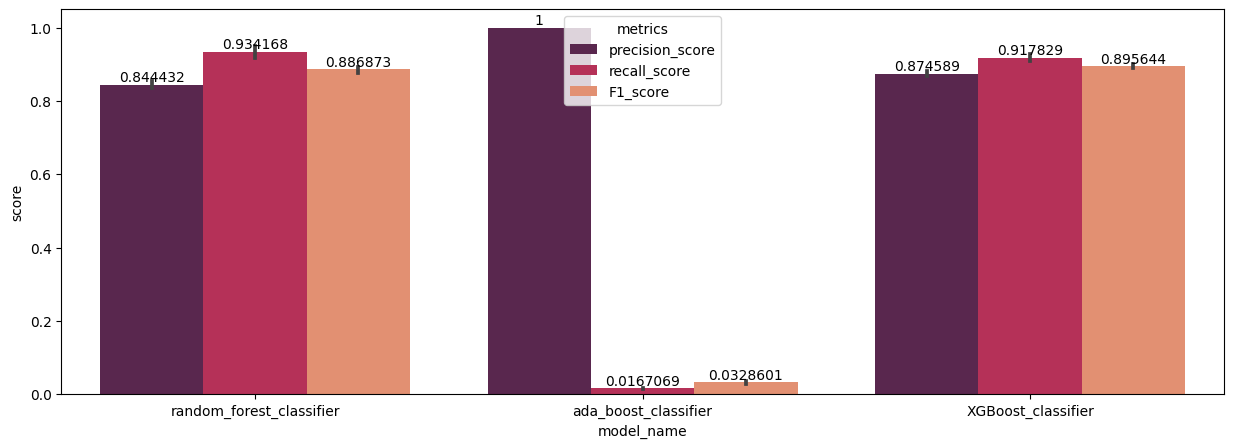

In [272]:
plt.figure(figsize=(15, 5))

ax = sns.barplot(data=model_comp_df, x='model_name', y='score', hue='metrics', palette='rocket')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

Comparing model wise performance considering metrices we can see that we are able to optimize AdaBoost is able to classify all the negative data points with 100% accuracy but at the cost of low recall and F1 score. But XGboost and RandomForest are able to do well on both positive and negative classes. By slightly adjusting the threshold using ROC we will be able to get precision score = 1 and minimum reduction in recall score.

In [273]:
model_comp_df[(model_comp_df['metrics'] == 'precision_score') & ((model_comp_df['model_name'] == 'random_forest_classifier') | (model_comp_df['model_name'] == 'XGBoost_classifier'))].sort_values('score', ascending=False).head(4)

,model_name,dataframe_type,metrics,score
24,XGBoost_classifier,chi2_with_out,precision_score,0.884813
6,XGBoost_classifier,feat_imp_with_out,precision_score,0.876934
33,XGBoost_classifier,chi2_without_out,precision_score,0.871717
15,XGBoost_classifier,feat_imp_without_out,precision_score,0.864893


## **Answers**

### **Task 1 : Consume this data and build a model to quantify the risk of a trial. The generated value should reflect how likely the trial is to fail**

**Risk Scorer Model**

Best combination seems to be :
    <p>Model : Random Forest Classifier</p>
    <p>Feature selection technique : chi square</p>
    <p>DataFrame Type : With Outliers</p>

To solve this instead of predicting classes, we will predict probability of the class 0. Which will indicate that how likely is that trail to fail.

In [274]:
best_param = dict(model_params['random_forest_classifier-chi2_with_out'])
model = RandomForestClassifier(**best_param)

df = dataframes['chi2_with_out']

X = df.drop(output_feature, axis=1)
y = df[output_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

cfm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cfm

array([[ 203,  206],
       [  97, 1216]], dtype=int64)

we can see that there are 206 negative data points which are getting wrongly classified. That is FP is not zero, which is the value we want to reduce to create a model which classifies all the failed studies with 100% accurcay. This can be done using threshold which needs to be calculated using ROC curve.

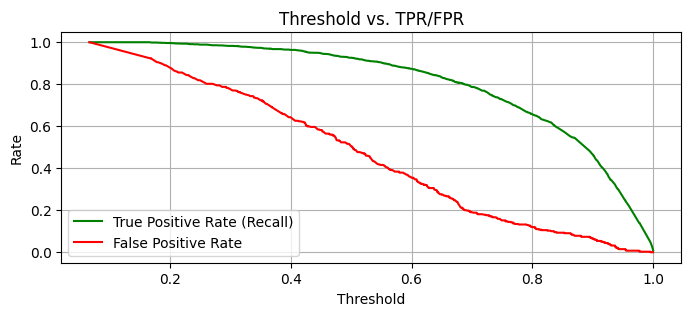

In [275]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1:2])
plt.figure(figsize=(8, 3))
plt.plot(thresholds, tpr, label='True Positive Rate (Recall)', color='green')
plt.plot(thresholds, fpr, label='False Positive Rate', color='red')
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Threshold vs. TPR/FPR")
plt.legend()
plt.grid()
plt.show()

In the above plot we can see that as to make False positive rate "0" we have to make threshold close to "1" which will make True positive rate "0" as well, This is the trade off. There is no way to reduce the FPR without decreasing TPR.
looking at the current confusion matrix.

In [276]:
cfm

array([[ 203,  206],
       [  97, 1216]], dtype=int64)

If we increase the threshold value to reduce FPR, more positive data points will get wrongly classified in turn increasing False Negative error. As shown in below example.

##### Using Custome Threshold

In [278]:
index = 0
for i in range(len(fpr)):

    if fpr[i] > 0.1002445:
        index = i
        break

index, thresholds[index]

(100, 0.8299742749532933)

In [279]:
cust_thresh = thresholds[index]
# cust_thresh = 0.8271011213243652

y_probs = model.predict_proba(X_test)

positive_probs = y_probs[:, 1:2]

new_y_pred = (positive_probs >= cust_thresh).astype(int)

confusion_matrix(y_pred=new_y_pred, y_true=y_test)

array([[367,  42],
       [501, 812]], dtype=int64)

Value of False Negative has increased.

So, ideally one should use a well balanced model which has good recall and precision score. or we can try to reduce the False positive error using different thresholds by discussing with domain experts, asking them how much False negative error is ok to have in this specific problem statement.

Answering the question : we will use predict_prob() functiion to tell how likely a trial is to fail.

In [280]:
model.classes_

array([0, 1], dtype=int64)

In [281]:
y_prob[:, :1]

array([[0.35389191],
       [0.08344995],
       [0.09205689],
       ...,
       [0.43354099],
       [0.68127868],
       [0.18680709]])

Above values indicate the chances of trial failing.

### **Task 2 : display the features that have had the most affect on the predicted failure of the trial.**

Since we have used Chi Square for feature selection, the top features with there significance values, which have the most influence on the predicated failure of the trial are : 

<p>City : 24684.766096</p>
<p>Title : 24090.021829</p>
<p>Sponsor : 14867.407553</p>
<p>Country : 5722.923923</p>
<p>Interventions : 1021.592428</p>
<p>Conditions : 427.9353192</p>